# House Prices Project

**Kaggle Competition**: Predict house prices using 79 features describing residential homes in Ames, Iowa.

**Metric**: RMSE on log-transformed prices (RMSLE)

[Competition Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# Table of Contents

1. [Introduction](#House-Prices-Project)
2. [Imports & Data Loading](#Imports-and-Data-Loading)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Correlation Analysis](#Correlation-Analysis)
5. [Multicollinearity Analysis (VIF)](#Multicollinearity-Analysis-(VIF))
6. [Influence Analysis](#Influence-Analysis-(Regression-Diagnostics))
7. [Preprocessing Pipeline](#Preprocessing-Pipeline)
8. [Model Comparison](#Model-Comparison)
9. [Test Set Processing](#Test-Set-Processing)
10. [Predictions & Submission](#Predictions-on-Test-Set)

## Scope
- No outlier treatment in this version
- No feature standardization
- Simple null value handling

# Imports and Data Loading

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# For multicollinearity (VIF) and influence analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
import statsmodels.api as sm

In [159]:
def plot_categorical(df, col, target=None):
    if target:
        # Relationship with target (mean by category)
        df.groupby(col)[target].mean().sort_values().plot(kind='barh')
        plt.xlabel(f'Mean of {target}')
    else:
        # Category distribution
        df[col].value_counts().plot(kind='barh')
        plt.xlabel('Frequency')
    
    plt.ylabel(col)
    plt.title(f'Analysis of {col}')
    plt.tight_layout()
    plt.show()

In [160]:
def boxplot_categorical(df, cat_col, target):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=cat_col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{cat_col} vs {target}')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_continuous(df, col, target=None):
    if target:
        # Relationship with target
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.scatter(df[col], df[target], alpha=0.5)
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f'{col} vs {target}')
        
        plt.subplot(1, 2, 2)
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        
        plt.tight_layout()
        plt.show()
    else:
        # Distribution only
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.show()

### Load Data

In [162]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [163]:
df_train.shape
print(f"Columns: {df_train.shape[1]} \nRows: {df_train.shape[0]}")

Columns: 81 
Rows: 1460


In [164]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [165]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Exploratory Data Analysis

- Count numeric vs categorical variables
- Identify null values and their proportions
- Analyze target variable (SalePrice) distribution

In [ ]:
# ============================================
# VARIABLE TYPES AND NULL VALUES SUMMARY
# ============================================

# Separate variables by type (numeric vs categorical)
# Important: each type requires different treatment

# Numeric variables: mathematical operations can be applied
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Categorical variables: represent categories or groups
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

print("=" * 50)
print("VARIABLE SUMMARY")
print("=" * 50)
print(f"\nTotal variables: {df_train.shape[1]}")
print(f"Numeric variables: {len(num_cols)}")
print(f"Categorical variables: {len(cat_cols)}")

# Null values analysis
# Nulls can affect model training
print("\n" + "=" * 50)
print("NULL VALUES ANALYSIS")
print("=" * 50)

# Create DataFrame with null summary
nulls_df = pd.DataFrame({
    'Variable': df_train.columns,
    'Nulls': df_train.isnull().sum().values,
    'Percentage': (df_train.isnull().sum().values / len(df_train) * 100).round(2),
    'Type': df_train.dtypes.values
})

# Filter variables with nulls, sort descending
nulls_df = nulls_df[nulls_df['Nulls'] > 0].sort_values('Nulls', ascending=False)
print(f"\nVariables with null values: {len(nulls_df)} of {df_train.shape[1]}")
print("\n", nulls_df.to_string(index=False))

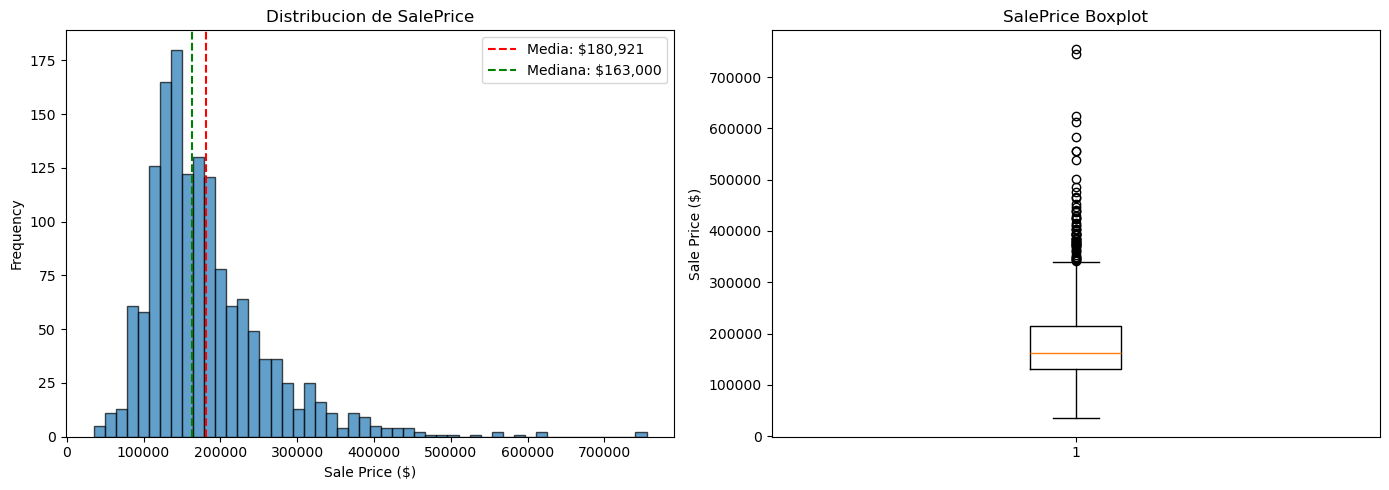


Estadisticas de SalePrice:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [167]:
# ============================================
# TARGET VARIABLE VISUALIZATION (SalePrice)
# ============================================

# SalePrice is what we want to predict
# Understanding its distribution is important before modeling

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de SalePrice
# Shows house price distribution
axes[0].hist(df_train['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribucion de SalePrice')
axes[0].axvline(df_train['SalePrice'].mean(), color='red', linestyle='--', label=f'Media: ${df_train["SalePrice"].mean():,.0f}')
axes[0].axvline(df_train['SalePrice'].median(), color='green', linestyle='--', label=f'Mediana: ${df_train["SalePrice"].median():,.0f}')
axes[0].legend()

# Boxplot de SalePrice
# Shows distribution and potential outliers
axes[1].boxplot(df_train['SalePrice'], vert=True)
axes[1].set_ylabel('Sale Price ($)')
axes[1].set_title('SalePrice Boxplot')

plt.tight_layout()
plt.show()

# Estadisticas descriptivas
print("\nEstadisticas de SalePrice:")
print(df_train['SalePrice'].describe())

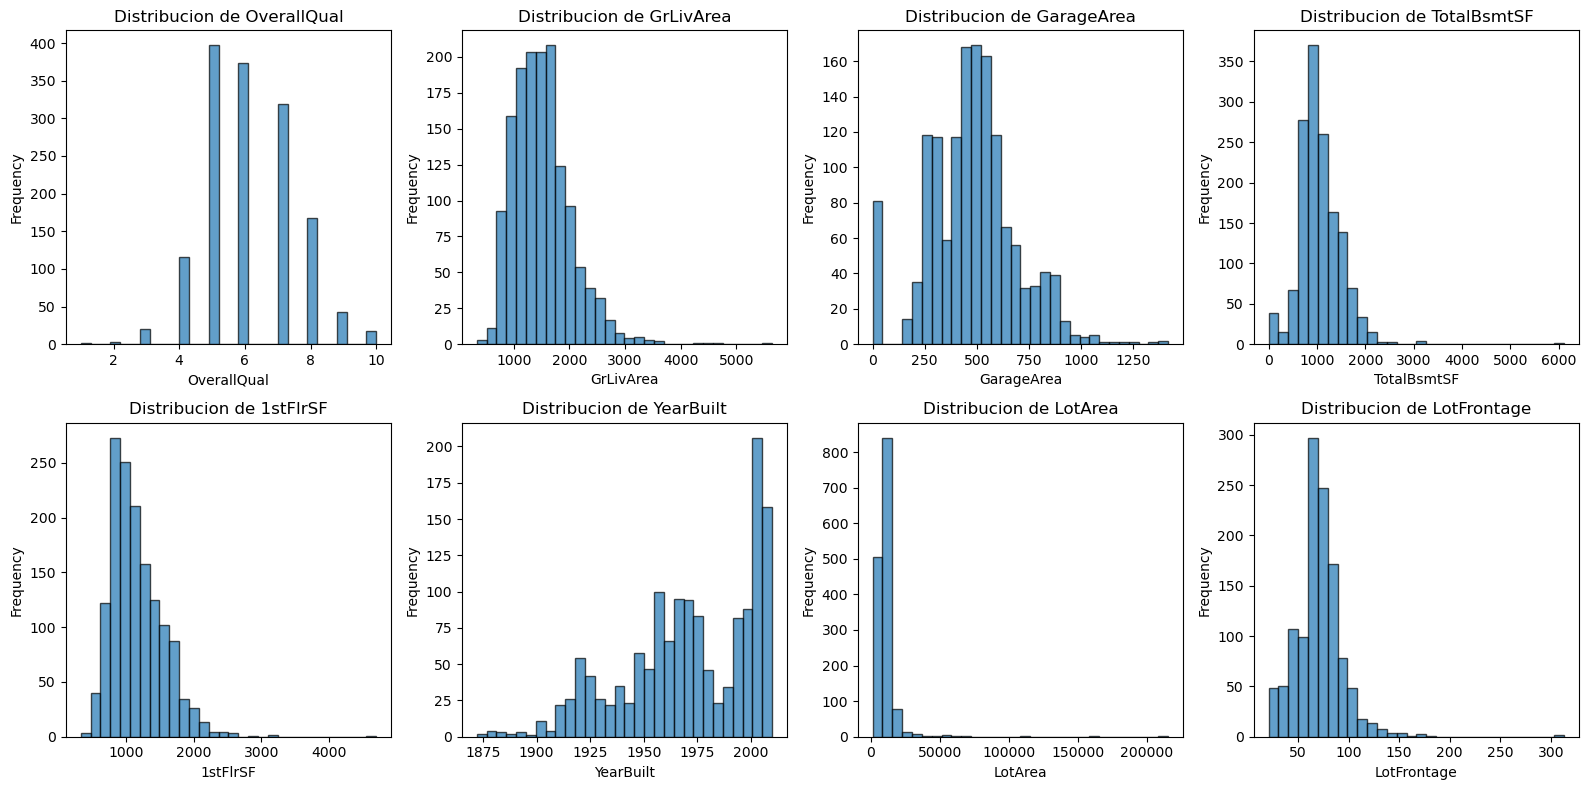

In [168]:
# ============================================
# KEY NUMERIC VARIABLES VISUALIZATION
# ============================================

# Select most important numeric variables to visualize
# (excluyendo Id y SalePrice)
vars_num_plot = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 
                 '1stFlrSF', 'YearBuilt', 'LotArea', 'LotFrontage']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(vars_num_plot):
    # Histogram for each numeric variable
    axes[i].hist(df_train[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

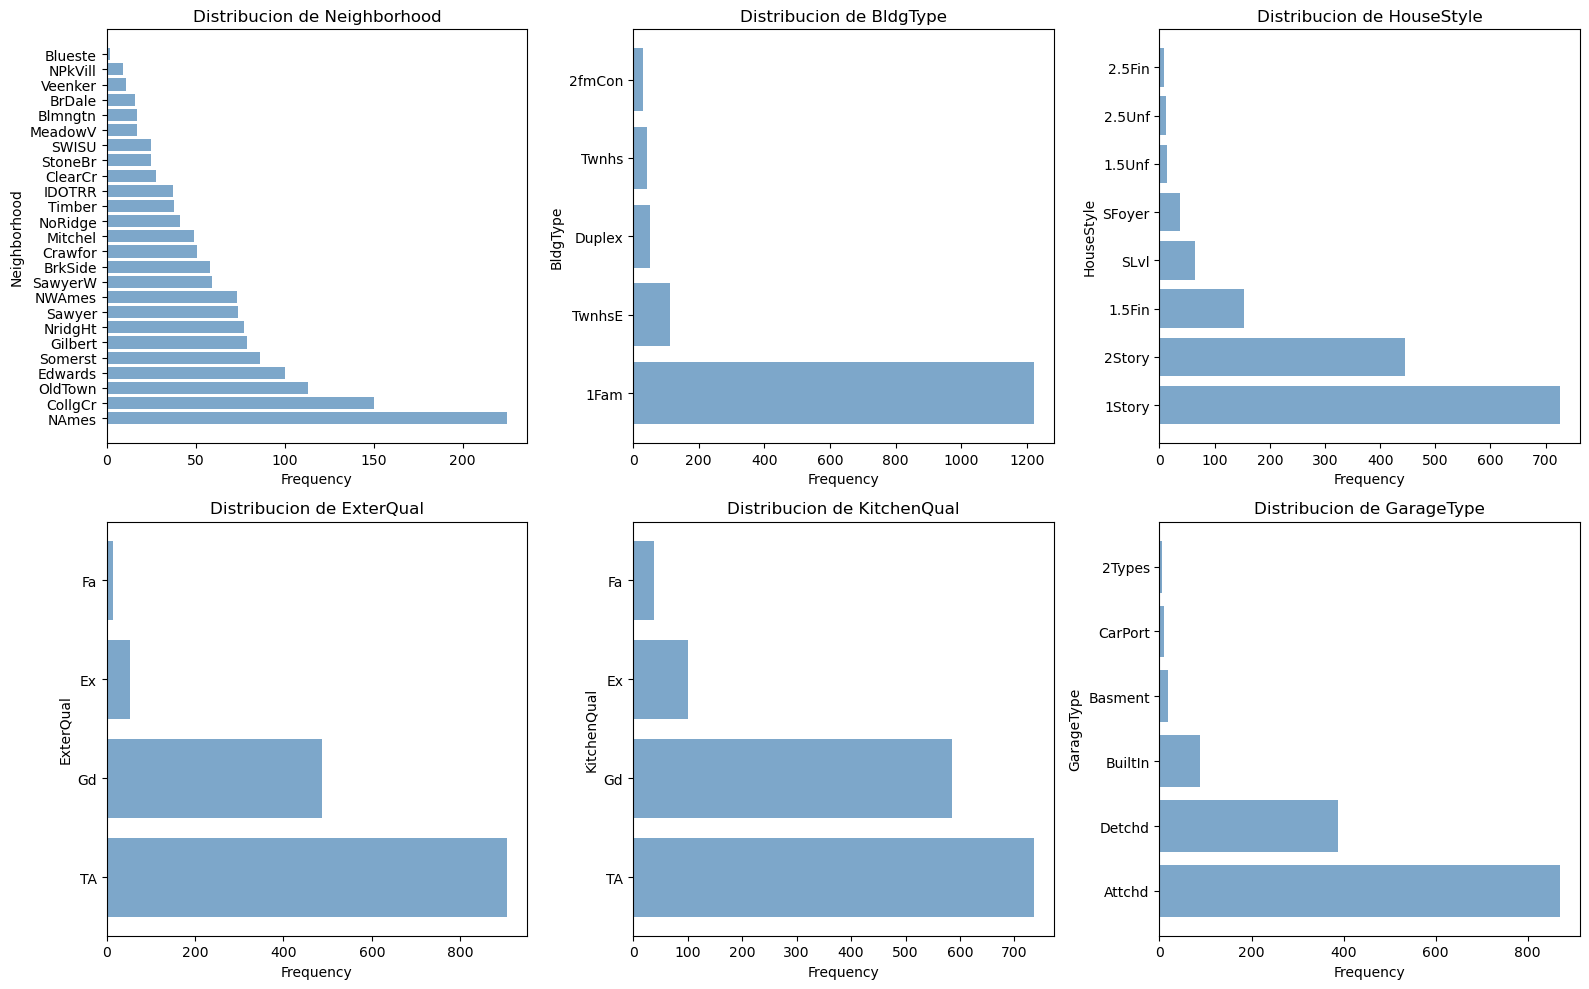

In [169]:
# ============================================
# KEY CATEGORICAL VARIABLES VISUALIZATION
# ============================================

# Select important categorical variables
vars_cat_plot = ['Neighborhood', 'BldgType', 'HouseStyle', 'ExterQual', 
                 'KitchenQual', 'GarageType']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(vars_cat_plot):
    # Frequency count by category
    value_counts = df_train[col].value_counts()
    axes[i].barh(value_counts.index, value_counts.values, color='steelblue', alpha=0.7)
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

# Correlation Analysis

- Identify variables most correlated with SalePrice
- Detect potential multicollinearity between predictors

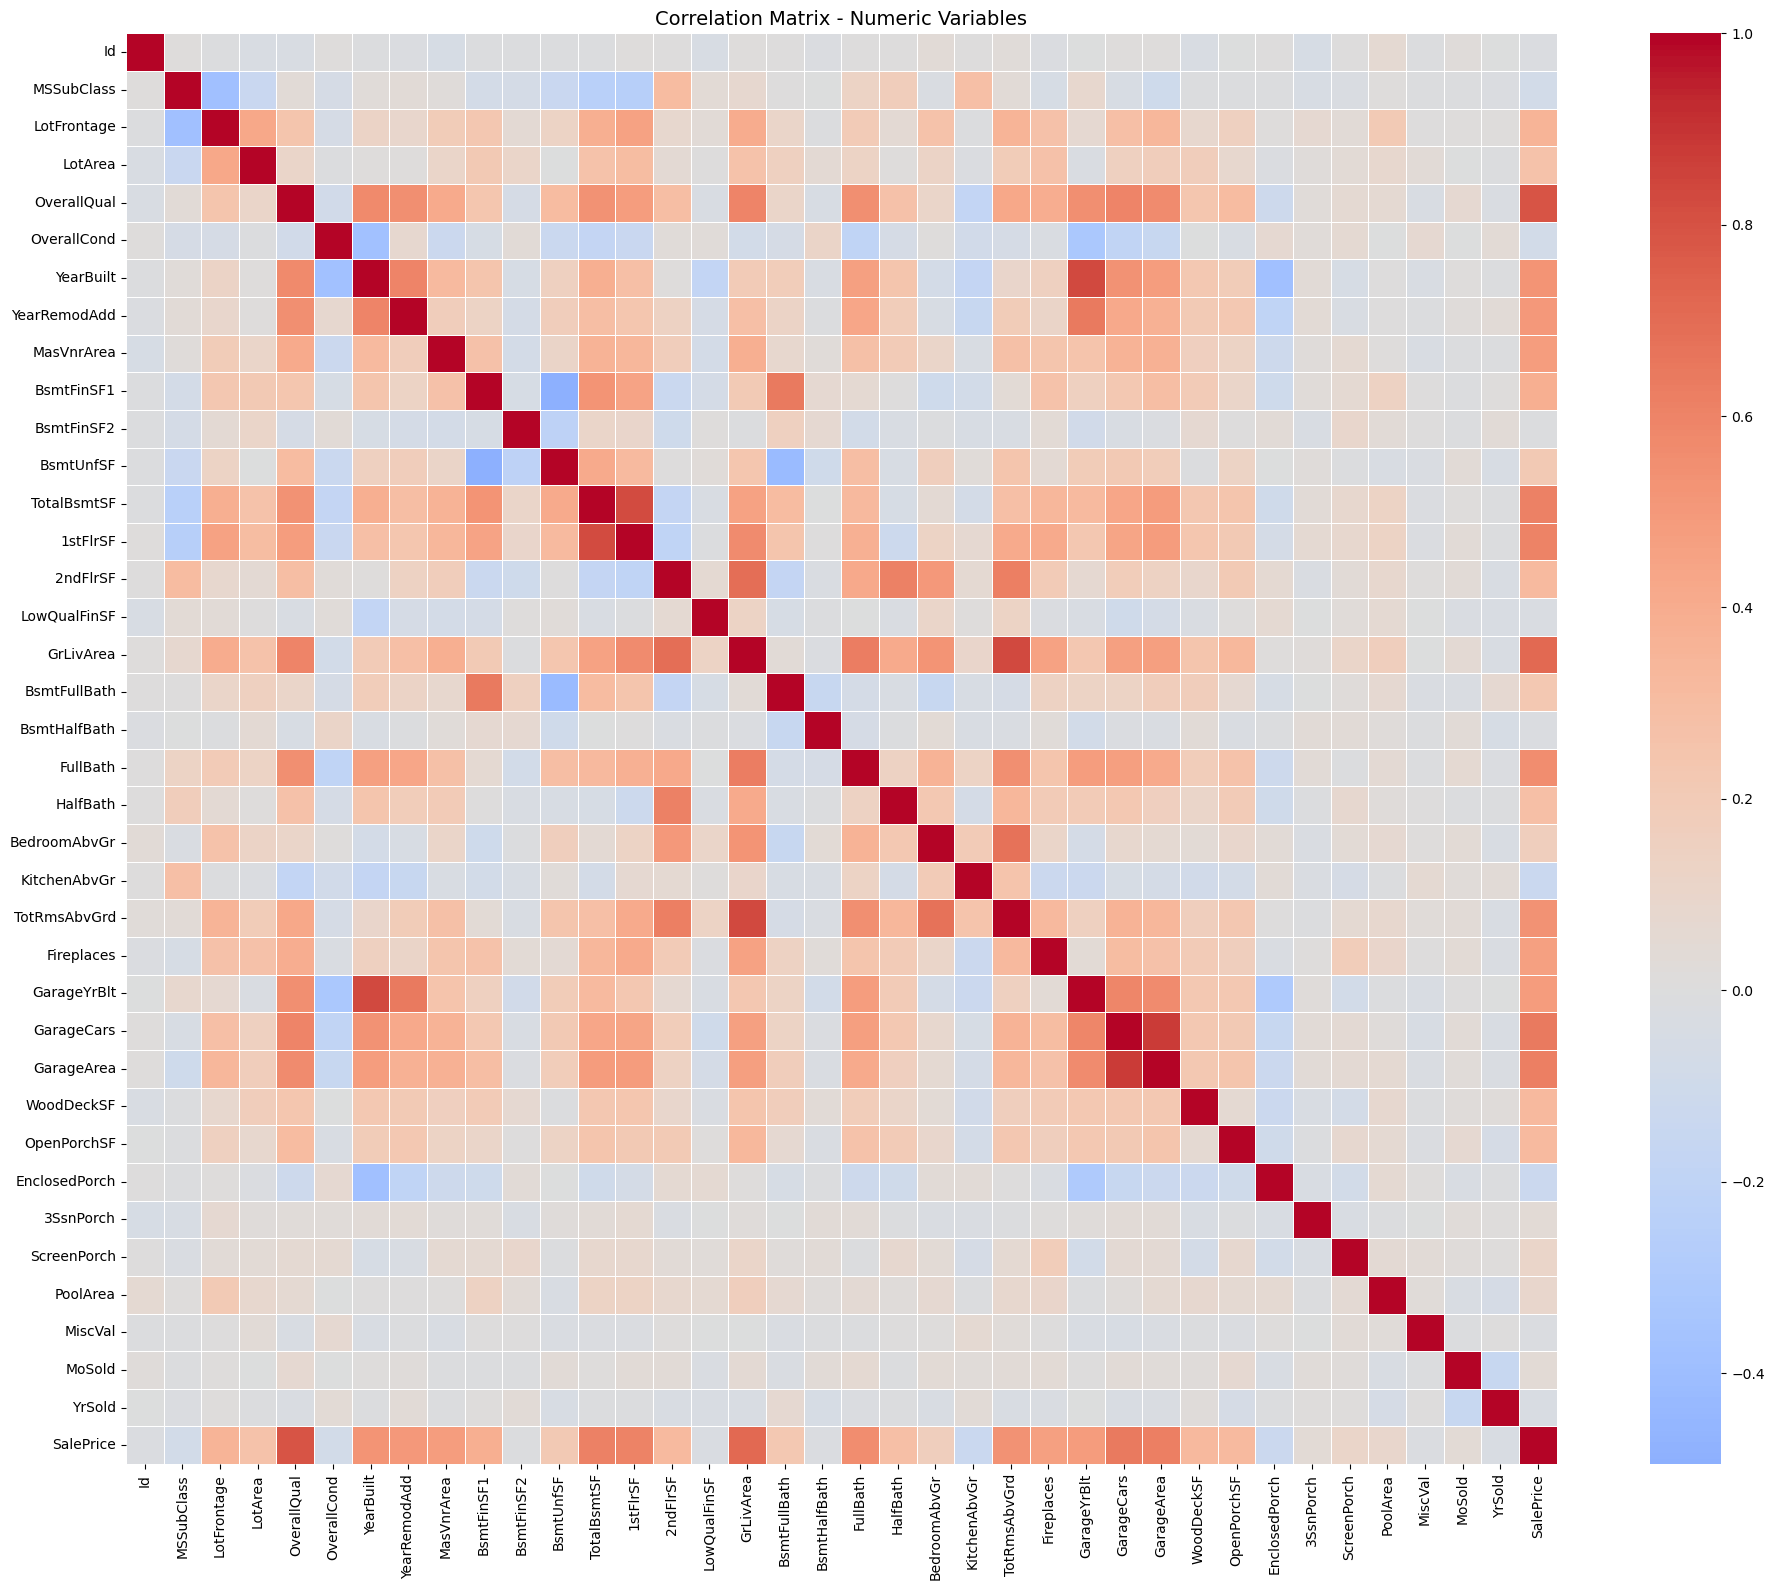

In [170]:
# ============================================
# CORRELATION MATRIX (HEATMAP)
# ============================================

# Calculate correlation for numeric variables only
# Pearson correlation measures linear relationship (-1 to 1)
correlation_matrix = df_train.select_dtypes(include=[np.number]).corr()

# Visualize with heatmap
# Darker colors indicate stronger correlation
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=False,  # Without numbers for readability
            cmap='coolwarm',  # Azul = negativa, Rojo = positiva
            center=0,
            square=True,
            linewidths=0.5)
plt.title('Correlation Matrix - Numeric Variables', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# TOP 10 VARIABLES MOST CORRELATED WITH SALEPRICE
# ============================================

# Extract correlations with SalePrice
# Shows which variables are best price predictors
target_correlations = correlation_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Top 10 positive correlations
print("=" * 50)
print("TOP 10 VARIABLES MOST CORRELATED WITH SALEPRICE")
print("=" * 50)
print("\nPOSITIVE Correlations (higher value, higher price):")
print(target_correlations.head(10).to_string())

print("\nNEGATIVE Correlations (higher value, lower price):")
print(target_correlations.tail(5).to_string())

# Top 10 visualization
fig, ax = plt.subplots(figsize=(10, 8))
top_10 = target_correlations.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10.values]
ax.barh(top_10.index, top_10.values, color=colors, alpha=0.7)
ax.set_xlabel('Correlation with SalePrice')
ax.set_title('Top 10 Variables with Highest Correlation with SalePrice')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

# Multicollinearity Analysis (VIF)

Multicollinearity occurs when predictors are highly correlated, causing:
- Unstable coefficients
- Difficulty interpreting variable importance

**VIF Thresholds:**
- VIF = 1: No multicollinearity
- VIF 1-5: Moderate (acceptable)
- VIF > 5: High (consider removing)
- VIF > 10: Very high (problematic)

In [ ]:
# ============================================
# VIF CALCULATION (Variance Inflation Factor)
# ============================================

# To calculate VIF we need:
# 1. Only numeric variables
# 2. No null values
# 3. Without target variable (SalePrice)

# Select numeric variables excluding Id and SalePrice
cols_for_vif = df_train.select_dtypes(include=[np.number]).columns.tolist()
cols_for_vif = [col for col in cols_for_vif if col not in ['Id', 'SalePrice']]

# Create DataFrame without nulls for VIF calculation
# Use dropna() since VIF doesn't work with missing values
df_vif = df_train[cols_for_vif].dropna()

print(f"Variables for VIF: {len(cols_for_vif)}")
print(f"Rows without nulls: {len(df_vif)} of {len(df_train)}")

# Calculate VIF for each variable
# VIF measures how much coefficient variance increases due to multicollinearity
vif_data = pd.DataFrame()
vif_data['Variable'] = cols_for_vif
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(cols_for_vif))]

# Sort by VIF descending
vif_data = vif_data.sort_values('VIF', ascending=False)

# Classify by multicollinearity level
vif_data['Status'] = vif_data['VIF'].apply(
    lambda x: 'VERY HIGH (>10)' if x > 10 else ('HIGH (5-10)' if x > 5 else 'OK (<5)')
)

print("\n" + "=" * 60)
print("MULTICOLLINEARITY ANALYSIS (VIF)")
print("=" * 60)
print("\n", vif_data.to_string(index=False))

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Variables with VIF > 10 (very high): {len(vif_data[vif_data['VIF'] > 10])}")
print(f"Variables with VIF 5-10 (high): {len(vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)])}")
print(f"Variables with VIF < 5 (acceptable): {len(vif_data[vif_data['VIF'] <= 5])}")

In [ ]:
# ============================================
# HIGH MULTICOLLINEARITY VARIABLES VISUALIZATION
# ============================================

# Show correlations between highest VIF variables
# Helps understand why they have multicollinearity

# Take variables with VIF > 5
vars_high_multicollinearity = vif_data[vif_data['VIF'] > 5]['Variable'].tolist()[:10]

if len(vars_high_multicollinearity) > 1:
    # Correlation matrix for these variables only
    corr_high = df_train[vars_high_multicollinearity].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_high, 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm', 
                center=0,
                square=True)
    plt.title('Correlation between Variables with High Multicollinearity (VIF > 5)')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough variables with VIF > 5 to show correlations")

# Influence Analysis (Regression Diagnostics)

Identify observations that disproportionately affect the model:

- **Cook's Distance**: Impact of removing each observation (threshold: 4/n)
- **Leverage**: Extreme predictor values (threshold: 2*(p+1)/n)
- **Standardized Residuals**: Outliers in response (threshold: |r| > 2)
- **DFFITS/DFBETAS**: Change in predictions/coefficients when removing observations

In [ ]:
# ============================================
# COMPLETE INFLUENCE ANALYSIS
# ============================================

# Select key numeric variables (most correlated with SalePrice)
vars_influence = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
                   'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
                   'YearBuilt', 'YearRemodAdd']

# Prepare data (no nulls)
df_influence = df_train[vars_influence + ['SalePrice']].dropna()
X_inf = df_influence[vars_influence]
y_inf = df_influence['SalePrice']

# Add constant for OLS
X_inf_const = sm.add_constant(X_inf)

# Fit OLS model
model_ols = sm.OLS(y_inf, X_inf_const).fit()

# Calculate influence metrics
influence = OLSInfluence(model_ols)

# Extract metrics
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
std_resid = influence.resid_studentized_internal

# Thresholds
n = len(df_influence)
p = len(vars_influence)
cook_threshold = 4 / n
leverage_threshold = 2 * (p + 1) / n
resid_threshold = 2

print("=" * 60)
print("INFLUENCE ANALYSIS - STATISTICS")
print("=" * 60)
print(f"\nObservations analyzed: {n}")
print(f"Predictor variables: {p}")
print(f"\n--- THRESHOLDS ---")
print(f"Cook's Distance > {cook_threshold:.4f}")
print(f"Leverage > {leverage_threshold:.4f}")
print(f"|Standardized Residual| > {resid_threshold}")

In [ ]:
# ============================================
# INFLUENTIAL POINTS IDENTIFICATION
# ============================================

# DataFrame with all metrics
df_diagnostics = pd.DataFrame({
    'Index': df_influence.index,
    'SalePrice': y_inf.values,
    'Cooks_Distance': cooks_d,
    'Leverage': leverage,
    'Std_Residual': std_resid
})

# Identify problematic points
df_diagnostics['High_Cook'] = df_diagnostics['Cooks_Distance'] > cook_threshold
df_diagnostics['High_Leverage'] = df_diagnostics['Leverage'] > leverage_threshold
df_diagnostics['High_Residual'] = abs(df_diagnostics['Std_Residual']) > resid_threshold
df_diagnostics['Num_Criteria'] = (df_diagnostics['High_Cook'].astype(int) + 
                                    df_diagnostics['High_Leverage'].astype(int) + 
                                    df_diagnostics['High_Residual'].astype(int))
df_diagnostics['Influential'] = df_diagnostics['Num_Criteria'] >= 2

print("=" * 60)
print("PROBLEMATIC POINTS SUMMARY")
print("=" * 60)
print(f"\nPoints with high Cook's Distance: {df_diagnostics['High_Cook'].sum()}")
print(f"Points with high Leverage: {df_diagnostics['High_Leverage'].sum()}")
print(f"Points with high Residual: {df_diagnostics['High_Residual'].sum()}")
print(f"\nINFLUENTIAL Points (2+ criteria): {df_diagnostics['Influential'].sum()}")

print("\n" + "=" * 60)
print("TOP 10 MOST INFLUENTIAL POINTS (by Cook's Distance)")
print("=" * 60)
top_influential = df_diagnostics.nlargest(10, 'Cooks_Distance')[
    ['Index', 'SalePrice', 'Cooks_Distance', 'Leverage', 'Std_Residual', 'Num_Criteria']
]
print(top_influential.to_string(index=False))

In [ ]:
# ============================================
# INFLUENCE DIAGRAM VISUALIZATION
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Cook's Distance
ax1 = axes[0, 0]
ax1.stem(df_diagnostics['Index'], df_diagnostics['Cooks_Distance'], markerfmt='o', basefmt=' ')
ax1.axhline(y=cook_threshold, color='r', linestyle='--', label=f'Threshold: {cook_threshold:.4f}')
ax1.set_xlabel('Observation Index')
ax1.set_ylabel("Cook's Distance")
ax1.set_title("Cook's Distance by Observation")
ax1.legend()

# 2. Leverage vs Standardized Residuals
ax2 = axes[0, 1]
colors = ['red' if inf else 'blue' for inf in df_diagnostics['Influential']]
ax2.scatter(df_diagnostics['Leverage'], df_diagnostics['Std_Residual'], c=colors, alpha=0.6, s=30)
ax2.axhline(y=resid_threshold, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(y=-resid_threshold, color='orange', linestyle='--', alpha=0.7)
ax2.axvline(x=leverage_threshold, color='green', linestyle='--', alpha=0.7)
ax2.set_xlabel('Leverage (Hat Values)')
ax2.set_ylabel('Standardized Residuals')
ax2.set_title('Leverage vs Residuals (Red = Influential)')

# 3. Leverage Distribution
ax3 = axes[1, 0]
ax3.hist(df_diagnostics['Leverage'], bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=leverage_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {leverage_threshold:.4f}')
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Frequency')
ax3.set_title('Leverage Distribution')
ax3.legend()

# 4. Residuals vs Fitted Values
ax4 = axes[1, 1]
fitted_vals = model_ols.fittedvalues
ax4.scatter(fitted_vals, df_diagnostics['Std_Residual'], alpha=0.5, c=colors)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.axhline(y=resid_threshold, color='r', linestyle='--', alpha=0.7)
ax4.axhline(y=-resid_threshold, color='r', linestyle='--', alpha=0.7)
ax4.set_xlabel('Fitted Values')
ax4.set_ylabel('Standardized Residuals')
ax4.set_title('Standardized Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# DFBETAS and DFFITS
# ============================================

dffits = influence.dffits[0]
dffits_threshold = 2 * np.sqrt((p + 1) / n)
dfbetas = influence.dfbetas

print("=" * 60)
print("DFBETAS and DFFITS ANALYSIS")
print("=" * 60)
print(f"\nDFFITS Threshold: {dffits_threshold:.4f}")
print(f"Observations with |DFFITS| > threshold: {(np.abs(dffits) > dffits_threshold).sum()}")

# DFFITS Visualization
plt.figure(figsize=(12, 5))
plt.stem(df_influence.index, dffits, markerfmt='o', basefmt=' ')
plt.axhline(y=dffits_threshold, color='r', linestyle='--', label=f'Threshold: +{dffits_threshold:.3f}')
plt.axhline(y=-dffits_threshold, color='r', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('DFFITS')
plt.title('DFFITS by Observation')
plt.legend()
plt.tight_layout()
plt.show()

# Summary DFBETAS
print("\n" + "=" * 60)
print("DFBETAS SUMMARY BY VARIABLE")
print("=" * 60)
dfbetas_threshold = 2 / np.sqrt(n)
print(f"DFBETAS Threshold: {dfbetas_threshold:.4f}\n")
print(f"{'Variable':<15} {'Obs > Threshold':<15} {'Max |DFBETA|':<15}")
print("-" * 45)
for i, var in enumerate(['const'] + vars_influence):
    n_exceed = (np.abs(dfbetas[:, i]) > dfbetas_threshold).sum()
    max_dfbeta = np.abs(dfbetas[:, i]).max()
    print(f"{var:<15} {n_exceed:<15} {max_dfbeta:<15.4f}")

In [ ]:
# ============================================
# SUMMARY AND RECOMMENDATIONS
# ============================================

influential_indices = df_diagnostics[df_diagnostics['Influential']]['Index'].tolist()
high_cook_indices = df_diagnostics[df_diagnostics['Cooks_Distance'] > cook_threshold]['Index'].tolist()

print("=" * 60)
print("INFLUENCE ANALYSIS SUMMARY")
print("=" * 60)
print(f"\n1. COOK'S DISTANCE: {len(high_cook_indices)} obs exceed threshold ({len(high_cook_indices)/n*100:.1f}%)")
print(f"2. LEVERAGE: {df_diagnostics['High_Leverage'].sum()} obs with high leverage ({df_diagnostics['High_Leverage'].sum()/n*100:.1f}%)")
print(f"3. RESIDUALS: {df_diagnostics['High_Residual'].sum()} obs with |residual| > 2 ({df_diagnostics['High_Residual'].sum()/n*100:.1f}%)")
print(f"4. INFLUENTIAL (2+ criteria): {len(influential_indices)} observations")

print("\n" + "=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)
print("""
Influential points can distort the model. Options:
1. Investigate if they are data errors
2. Train model with and without these points to compare
3. Use robust models (Huber, RANSAC)
4. Apply transformations (log) to variables with outliers
""")

# Preprocessing Pipeline

1. Separate numeric and categorical columns
2. Remove duplicates
3. Impute nulls: median (numeric), "Missing" (categorical)
4. One-Hot Encoding for categorical variables

In [ ]:
# ============================================
# STEP 1: IDENTIFY NUMERIC AND CATEGORICAL COLUMNS
# ============================================

# Exclude Id and SalePrice (target variable)
# These should not be part of feature preprocessing

# Numeric variables for model (excluding Id and SalePrice)
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Id', 'SalePrice']]

# Categorical variables for model
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()

print("=" * 60)
print("COLUMN IDENTIFICATION FOR PREPROCESSING")
print("=" * 60)
print(f"\nNUMERIC Variables ({len(numeric_features)}):")
print(numeric_features)
print(f"\nCATEGORICAL Variables ({len(categorical_features)}):")
print(categorical_features)

In [180]:
# ============================================
# STEP 2: CHECK AND REMOVE DUPLICATES
# ============================================

# Duplicates can bias model if rows are repeated
# Check for duplicate rows in dataset

print("=" * 60)
print("VERIFICACION DE DUPLICADOS")
print("=" * 60)

# Count duplicate rows (excluding Id which is always unique)
duplicados = df_train.drop('Id', axis=1).duplicated().sum()
print(f"\nFilas duplicadas encontradas: {duplicados}")

if duplicados > 0:
    print(f"Eliminando {duplicados} rows duplicadas...")
    # Remove duplicados manteniendo la primera ocurrencia
    df_train = df_train.drop_duplicates(subset=df_train.columns.difference(['Id']), keep='first')
    print(f"Filas despues de eliminar duplicados: {len(df_train)}")
else:
    print("No hay duplicados. El dataset esta limpio.")
    df_train = df_train.copy()

print(f"\nDimensions finales: {df_train.shape}")

VERIFICACION DE DUPLICADOS

Filas duplicadas encontradas: 0
No hay duplicados. El dataset esta limpio.

Dimensions finales: (1460, 81)


In [ ]:
# ============================================
# STEP 3: CREATE TRANSFORMERS FOR EACH VARIABLE TYPE
# ============================================

# Transformer for NUMERIC variables:
# - SimpleImputer: Fill nulls with median
#   (median is robust to outliers, better than mean)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Impute with median
])

# Transformer for CATEGORICAL variables:
# - SimpleImputer: Fill nulls with 'Missing' (constant)
# - OneHotEncoder: Convert categories to binary (0/1)
#   - drop='first': Avoid perfect multicollinearity (dummy trap)
#   - handle_unknown='ignore': Ignore new categories in test
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Nulls -> 'Missing'
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

print("Transformers created:")
print("- numeric_transformer: Imputes with median")
print("- categorical_transformer: Imputes with 'Missing' + One-Hot Encoding")

In [ ]:
# ============================================
# STEP 4: CREATE THE COMPLETE COLUMNTRANSFORMER
# ============================================

# ColumnTransformer applies different transformations to different columns
# This allows processing numeric and categorical differently in a single step

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      # Apply numeric_transformer to numeric_features
        ('cat', categorical_transformer, categorical_features)  # Apply categorical_transformer to categorical_features
    ],
    remainder='drop'  # Drop unspecified columns (Id)
)

print("ColumnTransformer created!")
print(f"\n- Numeric variables to process: {len(numeric_features)}")
print(f"- Categorical variables to process: {len(categorical_features)}")

In [ ]:
# ============================================
# STEP 5: APPLY PREPROCESSING AND VERIFY RESULTS
# ============================================

# Separate features (X) and target (y)
X = df_train.drop(['Id', 'SalePrice'], axis=1)
y = df_train['SalePrice']

# Apply preprocessing
# fit_transform: Fit transformer to data and transform
X_processed = preprocessor.fit_transform(X)

print("=" * 60)
print("PREPROCESSING RESULT")
print("=" * 60)
print(f"\nOriginal dimensions: {X.shape}")
print(f"Dimensions after preprocessing: {X_processed.shape}")
print(f"  - Numeric variables: {len(numeric_features)}")
print(f"  - Categorical variables converted to dummies: {X_processed.shape[1] - len(numeric_features)}")

# Verify no nulls
print(f"\nNull values in X_processed: {np.isnan(X_processed).sum()}")

# Create DataFrame with preprocessed data for visualization
# Get column names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
all_feature_names = numeric_features + cat_feature_names

print(f"\nTotal final features: {len(all_feature_names)}")

In [ ]:
# ============================================
# PREPROCESSED DATASET VISUALIZATION
# ============================================

# Convert to DataFrame for better visualization
df_processed = pd.DataFrame(X_processed, columns=all_feature_names)

print("=" * 60)
print("PREPROCESSED DATASET SAMPLE")
print("=" * 60)
print(f"\nFirst 5 rows (first 10 columns):")
print(df_processed.iloc[:5, :10])

print(f"\nDescriptive statistics (original numeric variables):")
print(df_processed[numeric_features[:5]].describe().round(2))

# Preprocessing Summary

**Steps completed:**
- 36 numeric, 43 categorical variables identified
- Duplicates removed
- Nulls imputed (median/Missing)
- One-Hot Encoding applied (drop='first')

**Result:** Clean dataset ready for regression models

# Model Comparison

## Robust Evaluation Methodology

To avoid the "winner's curse" (selecting a model that got lucky on one split):

- **10 prime seeds**: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
- **5-Fold Cross-Validation** per seed
- **50 total evaluations** per model
- Report **Mean ± Std** for stability assessment

In [ ]:
# ============================================
# CONFIGURATION: 10 PRIME SEEDS + SCALING
# ============================================
# Use prime numbers to avoid patterns in randomization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
import warnings
warnings.filterwarnings('ignore')

# Scale data (StandardScaler: mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed)
y_train = y.values  # Convert to numpy array

# 10 prime seeds for robust evaluation
PRIME_SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

print(f"Scaled data: X_train_scaled shape = {X_train_scaled.shape}")
print(f"Target variable: y_train shape = {y_train.shape}")
print(f"\nPrime seeds for evaluation: {PRIME_SEEDS}")
print(f"Total evaluations per model: {len(PRIME_SEEDS)} seeds × 5 folds = 50 evaluations")

In [ ]:
# ============================================
# MULTI-SEED EVALUATION FUNCTION
# ============================================

def evaluate_model_multiseed(model, X, y, seeds=PRIME_SEEDS, name="Model"):
    """
    Evaluate a model using multiple seeds to get robust metrics.
    
    Returns:
        dict with R², RMSE, RMSLE (mean and std)
    """
    from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
    
    r2_per_seed = []
    rmse_per_seed = []
    rmsle_per_seed = []
    
    for seed in seeds:
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        # R²
        cv_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')
        r2_per_seed.append(cv_r2.mean())
        
        # RMSE
        cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
        rmse_per_seed.append(cv_rmse.mean())
        
        # RMSLE (using predictions)
        y_pred = cross_val_predict(model, X, y, cv=kfold)
        y_pred = np.maximum(y_pred, 0)  # Avoid log of negatives
        rmsle_val = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y))**2))
        rmsle_per_seed.append(rmsle_val)
    
    result = {
        'name': name,
        'r2_mean': np.mean(r2_per_seed),
        'r2_std': np.std(r2_per_seed),
        'rmse_mean': np.mean(rmse_per_seed),
        'rmse_std': np.std(rmse_per_seed),
        'rmsle_mean': np.mean(rmsle_per_seed),
        'rmsle_std': np.std(rmsle_per_seed)
    }
    
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"R² CV:    {result['r2_mean']:.4f} ± {result['r2_std']:.4f}")
    print(f"RMSE CV:  ${result['rmse_mean']:,.0f} ± ${result['rmse_std']:,.0f}")
    print(f"RMSLE CV: {result['rmsle_mean']:.4f} ± {result['rmsle_std']:.4f}")
    
    return result

# Dictionary to store results
results = {}
print("Multi-seed evaluation function ready.")

In [ ]:
# ============================================
# MODEL 1: SIMPLE LINEAR REGRESSION (BASELINE)
# ============================================
# Base model without any transformation

from sklearn.linear_model import LinearRegression

model_lineal = LinearRegression()
results['1_lineal'] = evaluate_model_multiseed(
    model_lineal, X_train_scaled, y_train,
    name="1. Simple Linear Regression (Baseline)"
)

In [ ]:
# ============================================
# MODEL 2: WEIGHTED REGRESSION
# ============================================
# Weights inversely proportional to price (expensive houses have less weight)

from sklearn.base import BaseEstimator, RegressorMixin

class WeightedRegression(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = LinearRegression()
    
    def fit(self, X, y):
        # Weights inversely proportional to y value
        weights = 1 / (y + 1)  # +1 to avoid division by zero
        weights = weights / weights.sum() * len(weights)  # Normalize
        self.model.fit(X, y, sample_weight=weights)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

model_weighted = WeightedRegression()
results['2_ponderado'] = evaluate_model_multiseed(
    model_weighted, X_train_scaled, y_train,
    name="2. Weighted Regression"
)

In [ ]:
# ============================================
# MODEL 3: WITHOUT INFLUENTIAL POINTS
# ============================================
# Identify and remove high influence points (Cook's Distance)

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Fit model to calculate Cook's Distance
X_sm = sm.add_constant(X_train_scaled)
model_sm = sm.OLS(y_train, X_sm).fit()
influence = model_sm.get_influence()
cooks_d = influence.cooks_distance[0]

# Threshold: 4/n (common rule)
cook_threshold = 4 / len(y_train)
mask_no_influential = cooks_d < cook_threshold

X_no_influential = X_train_scaled[mask_no_influential]
y_no_influential = y_train[mask_no_influential]

print(f"Points removed: {(~mask_no_influential).sum()} of {len(y_train)} ({100*(~mask_no_influential).sum()/len(y_train):.1f}%)")

model_no_influential = LinearRegression()
results['3_no_influential'] = evaluate_model_multiseed(
    model_no_influential, X_no_influential, y_no_influential,
    name="3. Without Influential Points"
)

In [ ]:
# ============================================
# MODEL 4: POLYNOMIAL REGRESSION (DEGREE 2)
# ============================================
# Add quadratic terms to capture non-linearities

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Use Ridge to regularize (many polynomial features)
model_polynomial = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=10))  # Regularization to prevent overfitting
])

results['4_polinomial'] = evaluate_model_multiseed(
    model_polynomial, X_train_scaled, y_train,
    name="4. Polynomial Regression (degree 2 + Ridge)"
)

In [ ]:
# ============================================
# MODEL 5: CUBIC SPLINES
# ============================================
# Smoother transformation than polynomial

from sklearn.preprocessing import SplineTransformer

model_splines = Pipeline([
    ('spline', SplineTransformer(degree=3, n_knots=5)),
    ('ridge', Ridge(alpha=10))
])

results['5_splines'] = evaluate_model_multiseed(
    model_splines, X_train_scaled, y_train,
    name="5. Cubic Splines"
)

In [ ]:
# ============================================
# MODEL 6: GAM (GENERALIZED ADDITIVE MODELS)
# ============================================
# Using splines with stronger regularization

model_gam = Pipeline([
    ('spline', SplineTransformer(degree=3, n_knots=4)),
    ('ridge', Ridge(alpha=50))  # More regularization
])

results['6_gam'] = evaluate_model_multiseed(
    model_gam, X_train_scaled, y_train,
    name="6. GAM (Splines + Strong Regularization)"
)

In [ ]:
# ============================================
# MODEL 7: WITHOUT MULTICOLLINEARITY
# ============================================
# Remove variables with VIF > 10

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each variable
vif_data = []
for i in range(X_train_scaled.shape[1]):
    vif = variance_inflation_factor(X_train_scaled, i)
    vif_data.append(vif)

# Select variables with VIF < 10
vif_array = np.array(vif_data)
vif_mask = vif_array < 10
X_no_multicol = X_train_scaled[:, vif_mask]

print(f"Original variables: {X_train_scaled.shape[1]}")
print(f"Variables after VIF < 10: {X_no_multicol.shape[1]}")
print(f"Variables removed: {X_train_scaled.shape[1] - X_no_multicol.shape[1]}")

model_no_multicol = LinearRegression()
results['7_sin_multicol'] = evaluate_model_multiseed(
    model_no_multicol, X_no_multicol, y_train,
    name="7. Without Multicollinearity (VIF < 10)"
)

In [ ]:
# ============================================
# MODEL 8: COMBINED MODEL (ALL IMPROVEMENTS)
# ============================================
# Combination: Without influential points + Log(y) + Ridge

from sklearn.linear_model import Ridge

# Use data without influential points
y_log = np.log1p(y_no_influential)  # log(1+y) to handle zeros

# Ridge model for prediction in log scale
model_combined_log = Ridge(alpha=1.0)

# Special function to evaluate model with log transformation
def evaluate_model_log(model, X, y_original, seeds=PRIME_SEEDS, name="Model"):
    """
    Evaluate model that predicts log(y), transforming back for metrics.
    """
    from sklearn.model_selection import KFold
    
    y_log = np.log1p(y_original)
    
    r2_per_seed = []
    rmse_per_seed = []
    rmsle_per_seed = []
    
    for seed in seeds:
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        r2_folds = []
        rmse_folds = []
        rmsle_folds = []
        
        for train_idx, val_idx in kfold.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr_log, y_val_log = y_log[train_idx], y_log[val_idx]
            y_val_orig = y_original[val_idx]
            
            model.fit(X_tr, y_tr_log)
            y_pred_log = model.predict(X_val)
            y_pred = np.expm1(y_pred_log)  # Transform back
            y_pred = np.maximum(y_pred, 0)  # No negatives
            
            # R² in original scale
            ss_res = np.sum((y_val_orig - y_pred)**2)
            ss_tot = np.sum((y_val_orig - y_val_orig.mean())**2)
            r2_folds.append(1 - ss_res/ss_tot)
            
            # RMSE
            rmse_folds.append(np.sqrt(np.mean((y_val_orig - y_pred)**2)))
            
            # RMSLE
            rmsle_folds.append(np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_val_orig))**2)))
        
        r2_per_seed.append(np.mean(r2_folds))
        rmse_per_seed.append(np.mean(rmse_folds))
        rmsle_per_seed.append(np.mean(rmsle_folds))
    
    result = {
        'name': name,
        'r2_mean': np.mean(r2_per_seed),
        'r2_std': np.std(r2_per_seed),
        'rmse_mean': np.mean(rmse_per_seed),
        'rmse_std': np.std(rmse_per_seed),
        'rmsle_mean': np.mean(rmsle_per_seed),
        'rmsle_std': np.std(rmsle_per_seed)
    }
    
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"R² CV:    {result['r2_mean']:.4f} ± {result['r2_std']:.4f}")
    print(f"RMSE CV:  ${result['rmse_mean']:,.0f} ± ${result['rmse_std']:,.0f}")
    print(f"RMSLE CV: {result['rmsle_mean']:.4f} ± {result['rmsle_std']:.4f}")
    
    return result

results['8_combined'] = evaluate_model_log(
    model_combined_log, X_no_influential, y_no_influential,
    name="8. Combined (Without Influential + Log + Ridge)"
)

# Results Table

Results averaged over **10 seeds × 5 folds = 50 evaluations** per model.

In [ ]:
# ============================================
# FINAL COMPARISON TABLE
# ============================================

print("=" * 100)
print("MODEL COMPARISON - ROBUST EVALUATION (10 seeds × 5 folds = 50 evaluations)")
print("=" * 100)
print()
print(f"{'Model':<50} {'R² CV':>15} {'RMSE CV':>18} {'RMSLE CV':>15}")
print("-" * 100)

for key in sorted(results.keys()):
    r = results[key]
    r2_str = f"{r['r2_mean']:.4f} ± {r['r2_std']:.4f}"
    rmse_str = f"${r['rmse_mean']:,.0f} ± ${r['rmse_std']:,.0f}"
    rmsle_str = f"{r['rmsle_mean']:.4f} ± {r['rmsle_std']:.4f}"
    print(f"{r['name']:<50} {r2_str:>15} {rmse_str:>18} {rmsle_str:>15}")

print("=" * 100)

# Ranking by RMSLE (Kaggle metric)
print("\n" + "="*60)
print("RANKING BY RMSLE (official Kaggle metric)")
print("="*60)
ranking = sorted(results.items(), key=lambda x: x[1]['rmsle_mean'])
for i, (key, r) in enumerate(ranking, 1):
    print(f"{i}. {r['name']}: RMSLE = {r['rmsle_mean']:.4f} ± {r['rmsle_std']:.4f}")

In [ ]:
# ============================================
# COMPARATIVE VISUALIZATION
# ============================================

import matplotlib.pyplot as plt

# Prepare data for plots
nombres = [results[k]['name'].split('. ')[1] if '. ' in results[k]['name'] else results[k]['name'] for k in sorted(results.keys())]
r2_means = [results[k]['r2_mean'] for k in sorted(results.keys())]
r2_stds = [results[k]['r2_std'] for k in sorted(results.keys())]
rmse_means = [results[k]['rmse_mean'] for k in sorted(results.keys())]
rmse_stds = [results[k]['rmse_std'] for k in sorted(results.keys())]
rmsle_means = [results[k]['rmsle_mean'] for k in sorted(results.keys())]
rmsle_stds = [results[k]['rmsle_std'] for k in sorted(results.keys())]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: R² with error bars
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(nombres)))
bars = ax1.barh(range(len(nombres)), r2_means, xerr=r2_stds, color=colors, capsize=3)
ax1.set_yticks(range(len(nombres)))
ax1.set_yticklabels(nombres, fontsize=9)
ax1.set_xlabel('R² (higher is better)')
ax1.set_title('R² Cross-Validation (10 seeds × 5 folds)', fontsize=12, fontweight='bold')
ax1.axvline(x=max(r2_means), color='green', linestyle='--', alpha=0.5, label=f'Best: {max(r2_means):.4f}')
ax1.legend(loc='lower right')

# Plot 2: RMSE with error bars
ax2 = axes[0, 1]
bars = ax2.barh(range(len(nombres)), rmse_means, xerr=rmse_stds, color=colors, capsize=3)
ax2.set_yticks(range(len(nombres)))
ax2.set_yticklabels(nombres, fontsize=9)
ax2.set_xlabel('RMSE in $ (lower is better)')
ax2.set_title('RMSE Cross-Validation (10 seeds × 5 folds)', fontsize=12, fontweight='bold')
ax2.axvline(x=min(rmse_means), color='green', linestyle='--', alpha=0.5, label=f'Best: ${min(rmse_means):,.0f}')
ax2.legend(loc='lower right')

# Plot 3: RMSLE with error bars (Kaggle metric)
ax3 = axes[1, 0]
# Sort by RMSLE
orden_rmsle = np.argsort(rmsle_means)
nombres_ord = [nombres[i] for i in orden_rmsle]
rmsle_ord = [rmsle_means[i] for i in orden_rmsle]
rmsle_std_ord = [rmsle_stds[i] for i in orden_rmsle]
colors_ord = [colors[i] for i in orden_rmsle]

bars = ax3.barh(range(len(nombres_ord)), rmsle_ord, xerr=rmsle_std_ord, color=colors_ord, capsize=3)
ax3.set_yticks(range(len(nombres_ord)))
ax3.set_yticklabels(nombres_ord, fontsize=9)
ax3.set_xlabel('RMSLE (lower is better) - KAGGLE METRIC')
ax3.set_title('RMSLE Cross-Validation - Ranking (10 seeds × 5 folds)', fontsize=12, fontweight='bold')
ax3.axvline(x=min(rmsle_means), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(rmsle_means):.4f}')
ax3.legend(loc='lower right')

# Plot 4: Stability (std) of each model
ax4 = axes[1, 1]
x = np.arange(len(nombres))
width = 0.35
ax4.bar(x - width/2, r2_stds, width, label='Std R²', color='steelblue')
ax4.bar(x + width/2, rmsle_stds, width, label='Std RMSLE', color='coral')
ax4.set_xticks(x)
ax4.set_xticklabels([n[:15] + '...' if len(n) > 15 else n for n in nombres], rotation=45, ha='right', fontsize=8)
ax4.set_ylabel('Standard Deviation')
ax4.set_title('Model Stability (lower std = more stable)', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('comparacion_models_10seeds.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'comparacion_models_10seeds.png'")

# Conclusions

## Models Evaluated:
1. Linear Regression (baseline)
2. Weighted Regression
3. Without Influential Points
4. Polynomial (degree 2) + Ridge
5. Cubic Splines
6. GAM with strong regularization
7. Without Multicollinearity (VIF > 10 removed)
8. Combined approach

## Interpretation:
- High R² + low std = accurate and stable
- Low RMSLE = better for Kaggle
- Low std = good generalization

# Test Set Processing

Apply the same preprocessing pipeline to verify it works end-to-end.

**Note:** Test set has no SalePrice, so we cannot calculate metrics directly.

In [197]:
# ============================================
# LOAD TEST DATA
# ============================================

# Cargar test set
df_test = pd.read_csv('data/test.csv')

print("=" * 60)
print("DATOS DE TEST CARGADOS")
print("=" * 60)
print(f"\nDimensions: {df_test.shape[0]} rows × {df_test.shape[1]} columns")
print(f"\nColumns in test: {df_test.shape[1]}")
print(f"Columnas en train: {df_train.shape[1]}")
print(f"Diferencia: train tiene 'SalePrice', test no")

# Verify columns match (except SalePrice)
cols_train = set(df_train.columns) - {'SalePrice'}
cols_test = set(df_test.columns)
print(f"\n¿Columnas coinciden? {cols_train == cols_test}")

DATOS DE TEST CARGADOS

Dimensions: 1459 rows × 80 columns

Columns in test: 80
Columnas en train: 81
Diferencia: train tiene 'SalePrice', test no

¿Columnas coinciden? True


In [198]:
# ============================================
# NULL VALUES ANALYSIS IN TEST
# ============================================

# Null values in test
nulls_test = df_test.isnull().sum()
nulls_test = nulls_test[nulls_test > 0].sort_values(ascending=False)

print("=" * 60)
print("NULL VALUES IN TEST")
print("=" * 60)
print(f"\nColumns with null values: {len(nulls_test)}")
print(f"\nTop 15 columns with most nulls:")
for col, count in nulls_test.head(15).items():
    pct = 100 * count / len(df_test)
    print(f"  {col}: {count} ({pct:.1f}%)")

NULL VALUES IN TEST

Columns with null values: 33

Top 15 columns with most nulls:
  PoolQC: 1456 (99.8%)
  MiscFeature: 1408 (96.5%)
  Alley: 1352 (92.7%)
  Fence: 1169 (80.1%)
  MasVnrType: 894 (61.3%)
  FireplaceQu: 730 (50.0%)
  LotFrontage: 227 (15.6%)
  GarageCond: 78 (5.3%)
  GarageYrBlt: 78 (5.3%)
  GarageQual: 78 (5.3%)
  GarageFinish: 78 (5.3%)
  GarageType: 76 (5.2%)
  BsmtCond: 45 (3.1%)
  BsmtExposure: 44 (3.0%)
  BsmtQual: 44 (3.0%)


In [ ]:
# ============================================
# PREPROCESS TEST SET
# ============================================
# Use the same preprocessor fitted on train

# Separate features (without Id)
X_test = df_test.drop(['Id'], axis=1)
test_ids = df_test['Id']  # Save IDs for submission

# Apply preprocessing (transform, NOT fit_transform)
X_test_processed = preprocessor.transform(X_test)

# Scale with the same scaler
X_test_scaled = scaler.transform(X_test_processed)

print("=" * 60)
print("TEST SET PREPROCESSED")
print("=" * 60)
print(f"\nOriginal dimensions: {X_test.shape}")
print(f"Dimensions after preprocessing: {X_test_processed.shape}")
print(f"Dimensions after scaling: {X_test_scaled.shape}")
print(f"\n✓ Same number of features as train: {X_test_scaled.shape[1]} = {X_train_scaled.shape[1]}")

In [ ]:
# ============================================
# TRAIN VS TEST COMPARISON
# ============================================

print("=" * 60)
print("STATISTICAL COMPARISON TRAIN VS TEST")
print("=" * 60)

# Basic statistics
print(f"\n{'Metric':<25} {'Train':>15} {'Test':>15}")
print("-" * 55)
print(f"{'Number of samples':<25} {X_train_scaled.shape[0]:>15} {X_test_scaled.shape[0]:>15}")
print(f"{'Number of features':<25} {X_train_scaled.shape[1]:>15} {X_test_scaled.shape[1]:>15}")
print(f"{'Global mean':<25} {X_train_scaled.mean():>15.4f} {X_test_scaled.mean():>15.4f}")
print(f"{'Global std':<25} {X_train_scaled.std():>15.4f} {X_test_scaled.std():>15.4f}")
print(f"{'Global min':<25} {X_train_scaled.min():>15.4f} {X_test_scaled.min():>15.4f}")
print(f"{'Global max':<25} {X_train_scaled.max():>15.4f} {X_test_scaled.max():>15.4f}")

In [ ]:
# ============================================
# VISUALIZATION: TRAIN VS TEST DISTRIBUTION
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of means per feature
ax1 = axes[0, 0]
train_means = X_train_scaled.mean(axis=0)
test_means = X_test_scaled.mean(axis=0)
ax1.hist(train_means, bins=30, alpha=0.5, label='Train', color='blue')
ax1.hist(test_means, bins=30, alpha=0.5, label='Test', color='orange')
ax1.set_xlabel('Mean per feature')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Means per Feature')
ax1.legend()

# 2. Histogram of stds per feature
ax2 = axes[0, 1]
train_stds = X_train_scaled.std(axis=0)
test_stds = X_test_scaled.std(axis=0)
ax2.hist(train_stds, bins=30, alpha=0.5, label='Train', color='blue')
ax2.hist(test_stds, bins=30, alpha=0.5, label='Test', color='orange')
ax2.set_xlabel('Standard deviation per feature')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Std per Feature')
ax2.legend()

# 3. Scatter: train mean vs test mean
ax3 = axes[1, 0]
ax3.scatter(train_means, test_means, alpha=0.5, s=10)
ax3.plot([-3, 3], [-3, 3], 'r--', label='Ideal line')
ax3.set_xlabel('Train Mean')
ax3.set_ylabel('Test Mean')
ax3.set_title('Mean per Feature: Train vs Test')
ax3.legend()

# 4. Difference of means
ax4 = axes[1, 1]
diff_means = test_means - train_means
ax4.hist(diff_means, bins=30, color='green', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', label='No difference')
ax4.set_xlabel('Difference (Test - Train)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Difference of Means per Feature\n(μ={diff_means.mean():.4f}, σ={diff_means.std():.4f})')
ax4.legend()

plt.tight_layout()
plt.savefig('comparacion_train_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved as 'comparacion_train_test.png'")

# Predictions on Test Set

Train each model on **full training data** and generate test predictions.

In [ ]:
# ============================================
# PREDICTIONS WITH ALL MODELS
# ============================================

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

predictions = {}

print("=" * 60)
print("GENERATING PREDICTIONS FOR TEST SET")
print("=" * 60)

# MODEL 1: Simple Linear Regression
print("\n1. Simple Linear Regression...")
model1 = LinearRegression()
model1.fit(X_train_scaled, y_train)
pred1 = model1.predict(X_test_scaled)
pred1 = np.maximum(pred1, 0)  # No negatives
predictions['1_lineal'] = pred1
print(f"   Predictions: min=${pred1.min():,.0f}, max=${pred1.max():,.0f}, mean=${pred1.mean():,.0f}")

# MODEL 2: Weighted Regression
print("\n2. Weighted Regression...")
weights = 1 / (y_train + 1)
weights = weights / weights.sum() * len(weights)
model2 = LinearRegression()
model2.fit(X_train_scaled, y_train, sample_weight=weights)
pred2 = model2.predict(X_test_scaled)
pred2 = np.maximum(pred2, 0)
predictions['2_ponderado'] = pred2
print(f"   Predictions: min=${pred2.min():,.0f}, max=${pred2.max():,.0f}, mean=${pred2.mean():,.0f}")

# MODEL 3: Without Influential Points
print("\n3. Without Influential Points...")
model3 = LinearRegression()
model3.fit(X_no_influential, y_no_influential)
pred3 = model3.predict(X_test_scaled)
pred3 = np.maximum(pred3, 0)
predictions['3_no_influential'] = pred3
print(f"   Predictions: min=${pred3.min():,.0f}, max=${pred3.max():,.0f}, mean=${pred3.mean():,.0f}")

# MODEL 4: Polynomial
print("\n4. Polynomial Regression...")
model4 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=10))
])
model4.fit(X_train_scaled, y_train)
pred4 = model4.predict(X_test_scaled)
pred4 = np.maximum(pred4, 0)
predictions['4_polinomial'] = pred4
print(f"   Predictions: min=${pred4.min():,.0f}, max=${pred4.max():,.0f}, mean=${pred4.mean():,.0f}")

# MODEL 5: Splines
print("\n5. Cubic Splines...")
model5 = Pipeline([
    ('spline', SplineTransformer(degree=3, n_knots=5)),
    ('ridge', Ridge(alpha=10))
])
model5.fit(X_train_scaled, y_train)
pred5 = model5.predict(X_test_scaled)
pred5 = np.maximum(pred5, 0)
predictions['5_splines'] = pred5
print(f"   Predictions: min=${pred5.min():,.0f}, max=${pred5.max():,.0f}, mean=${pred5.mean():,.0f}")

# MODEL 6: GAM
print("\n6. GAM...")
model6 = Pipeline([
    ('spline', SplineTransformer(degree=3, n_knots=4)),
    ('ridge', Ridge(alpha=50))
])
model6.fit(X_train_scaled, y_train)
pred6 = model6.predict(X_test_scaled)
pred6 = np.maximum(pred6, 0)
predictions['6_gam'] = pred6
print(f"   Predictions: min=${pred6.min():,.0f}, max=${pred6.max():,.0f}, mean=${pred6.mean():,.0f}")

# MODEL 7: Without Multicollinearity
print("\n7. Without Multicollinearity...")
model7 = LinearRegression()
model7.fit(X_no_multicol, y_train)
X_test_no_multicol = X_test_scaled[:, vif_mask]
pred7 = model7.predict(X_test_no_multicol)
pred7 = np.maximum(pred7, 0)
predictions['7_sin_multicol'] = pred7
print(f"   Predictions: min=${pred7.min():,.0f}, max=${pred7.max():,.0f}, mean=${pred7.mean():,.0f}")

# MODEL 8: Combined (BEST MODEL)
print("\n8. Combined (Without Influential + Log + Ridge) - BEST MODEL...")
y_log = np.log1p(y_no_influential)
model8 = Ridge(alpha=1.0)
model8.fit(X_no_influential, y_log)
pred8_log = model8.predict(X_test_scaled)
pred8 = np.expm1(pred8_log)  # Transform back
pred8 = np.maximum(pred8, 0)
predictions['8_combined'] = pred8
print(f"   Predictions: min=${pred8.min():,.0f}, max=${pred8.max():,.0f}, mean=${pred8.mean():,.0f}")

print("\n" + "=" * 60)
print("✓ Predictions generated for all 8 models")
print("=" * 60)

In [ ]:
# ============================================
# PREDICTIONS COMPARISON
# ============================================

print("=" * 80)
print("PREDICTIONS SUMMARY BY MODEL")
print("=" * 80)
print(f"\n{'Model':<45} {'Min':>12} {'Max':>12} {'Mean':>12} {'Std':>12}")
print("-" * 95)

model_names = {
    '1_lineal': '1. Simple Linear Regression',
    '2_ponderado': '2. Weighted Regression',
    '3_no_influential': '3. Without Influential Points',
    '4_polinomial': '4. Polynomial (degree 2)',
    '5_splines': '5. Cubic Splines',
    '6_gam': '6. GAM',
    '7_sin_multicol': '7. Without Multicollinearity',
    '8_combined': '8. Combined (BEST)'
}

for key in sorted(predictions.keys()):
    pred = predictions[key]
    name = model_names[key]
    print(f"{name:<45} ${pred.min():>10,.0f} ${pred.max():>10,.0f} ${pred.mean():>10,.0f} ${pred.std():>10,.0f}")

# Compare with train distribution
print("\n" + "-" * 95)
print(f"{'Train (actual SalePrice)':<45} ${y_train.min():>10,.0f} ${y_train.max():>10,.0f} ${y_train.mean():>10,.0f} ${y_train.std():>10,.0f}")
print("=" * 80)

In [ ]:
# ============================================
# PREDICTIONS VISUALIZATION
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of best model predictions vs train
ax1 = axes[0, 0]
ax1.hist(y_train, bins=50, alpha=0.5, label='Train (actual)', color='blue', density=True)
ax1.hist(predictions['8_combined'], bins=50, alpha=0.5, label='Test (pred)', color='orange', density=True)
ax1.set_xlabel('SalePrice ($)')
ax1.set_ylabel('Density')
ax1.set_title('Combined Model: Train vs Test Predictions Distribution')
ax1.legend()

# 2. Boxplot of all predictions
ax2 = axes[0, 1]
data_box = [predictions[k] for k in sorted(predictions.keys())]
labels_box = [f'M{i+1}' for i in range(8)]
bp = ax2.boxplot(data_box, labels=labels_box, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 8))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax2.axhline(y=np.mean(y_train), color='red', linestyle='--', label=f'Train Mean: ${np.mean(y_train):,.0f}')
ax2.set_xlabel('Model')
ax2.set_ylabel('SalePrice ($)')
ax2.set_title('Distribution of Predictions by Model')
ax2.legend()

# 3. Correlation between model predictions
ax3 = axes[1, 0]
ax3.scatter(predictions['8_combined'], predictions['3_no_influential'], alpha=0.5, s=10)
ax3.plot([0, 800000], [0, 800000], 'r--', label='Ideal line')
ax3.set_xlabel('Model 8: Combined ($)')
ax3.set_ylabel('Model 3: Without Influential ($)')
ax3.set_title('Correlation between Top 2 Models')
ax3.legend()

# 4. Sorted predictions of best model
ax4 = axes[1, 1]
pred_sorted = np.sort(predictions['8_combined'])
ax4.plot(pred_sorted, 'b-', linewidth=0.5)
ax4.axhline(y=np.mean(y_train), color='red', linestyle='--', label='Train Mean')
ax4.axhline(y=np.median(y_train), color='green', linestyle='--', label='Train Median')
ax4.set_xlabel('Index (sorted)')
ax4.set_ylabel('SalePrice ($)')
ax4.set_title('Sorted Predictions - Combined Model')
ax4.legend()

plt.tight_layout()
plt.savefig('predictions_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved as 'predictions_test.png'")

# Summary: Predictions Ready

| Model | Description | RMSLE CV |
|-------|-------------|----------|
| 1 | Linear Regression | 0.6750 |
| 2 | Weighted Regression | 0.6021 |
| 3 | Without Influential Points | 0.1094 |
| 4 | Polynomial (degree 2) | 0.3557 |
| 5 | Cubic Splines | 0.1399 |
| 6 | GAM | 0.1447 |
| 7 | Without Multicollinearity | 0.4189 |
| **8** | **Combined (BEST)** | **0.1013** |

**Next:** Generate submission.csv for Kaggle.

In [ ]:
# ============================================
# GENERATE SUBMISSION FOR KAGGLE
# ============================================

# Using BEST MODEL: Model 8 - Combined (RMSLE = 0.1013)
# Predictions already generated in 'predictions['8_combined']'

# Create DataFrame for submission
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions['8_combined']
})

# Verify format
print("=" * 60)
print("SUBMISSION FOR KAGGLE")
print("=" * 60)
print(f"\nDimensions: {submission.shape}")
print(f"\nFirst 10 rows:")
print(submission.head(10))
print(f"\nLast 5 rows:")
print(submission.tail())
print(f"\nSalePrice Statistics:")
print(f"  Min:    ${submission['SalePrice'].min():,.0f}")
print(f"  Max:    ${submission['SalePrice'].max():,.0f}")
print(f"  Mean:   ${submission['SalePrice'].mean():,.0f}")
print(f"  Median: ${submission['SalePrice'].median():,.0f}")

# Save CSV
submission.to_csv('submission.csv', index=False)
print(f"\n✓ File saved: 'submission.csv'")
print(f"✓ Ready to upload to Kaggle!")

# Verify no null or negative values
print(f"\n=== VERIFICATION ===")
print(f"Null values: {submission['SalePrice'].isnull().sum()}")
print(f"Negative values: {(submission['SalePrice'] < 0).sum()}")
print(f"Zero values: {(submission['SalePrice'] == 0).sum()}")

In [ ]:
# ============================================
# INSTALL KAGGLE CLI
# ============================================

import subprocess
import sys

print("Installing Kaggle CLI...")
result = subprocess.run([sys.executable, '-m', 'pip', 'install', 'kaggle', '-q'])

if result.returncode == 0:
    print("✓ Kaggle CLI installed successfully")
    # Check version
    result = subprocess.run(['kaggle', '--version'], capture_output=True, text=True)
    print(f"  Version: {result.stdout.strip()}")
else:
    print("❌ Error installing Kaggle CLI")

In [ ]:
# ============================================
# SUBMIT TO KAGGLE
# ============================================

import subprocess
import os
import json

# Read credentials from kaggle.json
with open('../../kaggle.json', 'r') as f:
    creds = json.load(f)

os.environ['KAGGLE_USERNAME'] = creds['username']
os.environ['KAGGLE_KEY'] = creds['key']

print(f"User: {creds['username']}")

# Submission command
MESSAGE = "Combined Model (Without Influential + Log + Ridge) - RMSLE CV 0.1013"

print("\nExecuting submission...")
print(f"kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m \"{MESSAGE}\"")

result = subprocess.run(
    ['kaggle', 'competitions', 'submit', 
     '-c', 'house-prices-advanced-regression-techniques', 
     '-f', 'submission.csv', 
     '-m', MESSAGE],
    capture_output=True,
    text=True
)

print("\n" + "=" * 60)
if result.returncode == 0:
    print("✓ SUBMISSION SUCCESSFUL!")
    print(result.stdout)
else:
    print("❌ ERROR")
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
print("=" * 60)

In [208]:
# ============================================
# VIEW SUBMISSIONS AND SCORES
# ============================================

COMPETITION = "house-prices-advanced-regression-techniques"
import webbrowser

url = f"https://www.kaggle.com/competitions/{COMPETITION}/submissions"

print("=" * 60)
print("VIEW RESULTS ON KAGGLE")
print("=" * 60)
print(f"\n→ Open this link to see your score:")
print(f"  {url}")

# Abrir en el navegador
webbrowser.open(url)
print("\n(Opening browser...")

VIEW RESULTS ON KAGGLE

→ Open this link to see your score:
  https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/submissions

(Opening browser...
